# PREDICTING PRIMARY CONTRIBUTORS TO ROAD TRAFFIC CRASHES

## Business Problem

Road Traffic crashes have become a major public saftey concern. With a rise in number of crashes in recent times, it is imparative to identify the primary factors contributing to crashes. By doing so, the Department of Road Safety can thereby surport targeted interventions, enforcement strategies and improved road infrastructure. 

## Objectives
1. Identify top 10 causes of road accidents in Chicago
2. To determine whether impaired driver conditions are associated with specific contributory causes
3. To investigate how crash frequency and severity differ by presence and type of traffic control devices
4. To identify measures that can be put in place to mitigate road traffic crashes
5. To develop a multiclass classification model that predicts the primary contributory causes of crashes


### Carrying out necessary imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Data Loading

In [61]:
crashes = pd.read_csv("data\Traffic_Crashes_-_Crashes.csv.gz")
crashes.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,NaN,12/30/2025 11:50:00 PM,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,...,0.0,1.0,1.0,0.0,23,3,12,41.743702,-87.624186,POINT (-87.624185929083 41.743702317364)
1,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,NaN,12/30/2025 11:21:00 PM,30,UNKNOWN,UNKNOWN,SNOW,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,...,0.0,0.0,1.0,0.0,23,3,12,41.853734,-87.653792,POINT (-87.653792075361 41.85373399224)
2,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,NaN,12/30/2025 10:55:00 PM,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,22,3,12,41.906573,-87.687268,POINT (-87.687268089375 41.906573215648)
3,40064b1f9d498293c9392d4c89bb60128409738a3c44d1...,NaN,12/30/2025 10:51:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,...,0.0,1.0,3.0,0.0,22,3,12,41.807373,-87.622931,POINT (-87.622930554709 41.807373001937)
4,efce3ab254c9daaacb6ce6a60e10e8cb8ca50ab3f7ea5b...,NaN,12/30/2025 10:43:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",TURNING,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,22,3,12,41.928409,-87.702567,POINT (-87.702567230162 41.928408615992)


In [62]:
people = pd.read_csv("data\Traffic_Crashes_-_People.csv.gz")
people.head()

c:\Users\This pc\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O2218091,DRIVER,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,2114560.0,12/30/2025 11:50:00 PM,NaN,CHICAGO,IL,60617,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O2218092,DRIVER,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,2114556.0,12/30/2025 11:50:00 PM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O2218087,DRIVER,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,2114554.0,12/30/2025 11:21:00 PM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O2218080,DRIVER,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,2114549.0,12/30/2025 10:55:00 PM,NaN,CHICAGO,IL,60660,M,...,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O2218081,DRIVER,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,2114552.0,12/30/2025 10:55:00 PM,NaN,CHICAGO,IL,60618,M,...,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [63]:
vehicles = pd.read_csv("data\Traffic_Crashes_-_Vehicles.csv.gz")
vehicles.head()

c:\Users\This pc\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,39,40,41,47,48,49,57,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,2218091,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,12/30/2025 11:50:00 PM,2,DRIVER,NaN,2114560.0,NaN,HYUNDAI,ELANTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2218092,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,12/30/2025 11:50:00 PM,1,DRIVER,NaN,2114556.0,NaN,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2218087,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,12/30/2025 11:21:00 PM,1,DRIVER,NaN,2114554.0,NaN,GENERAL MOTORS CORPORATION (GMC),OTHER (EXPLAIN IN NARRATIVE),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2218080,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,12/30/2025 10:55:00 PM,1,DRIVER,NaN,2114549.0,NaN,LEXUS,RX400H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2218081,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,12/30/2025 10:55:00 PM,2,DRIVER,NaN,2114552.0,NaN,CHEVROLET,MALIBU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

In [64]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [65]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,54959.000000,6.00000,54959.000000,54959.000000,54959.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.000000,54854.0,54959.000000,54959.000000,54959.000000,54401.000000,54401.000000
mean,28.416329,3.00000,3641.048400,1274.461035,2.032915,0.237084,0.000966,0.016899,0.122671,0.096547,1.951416,0.0,13.117160,4.082734,9.386615,41.856150,-87.669265
std,5.566449,1.67332,2798.151399,702.797283,0.424157,0.628183,0.034410,0.148113,0.443796,0.406335,1.117474,0.0,5.582133,1.977496,1.703051,0.482557,0.996301
min,0.000000,2.00000,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,7.000000,0.000000,-87.939678
25%,30.000000,2.00000,1300.000000,735.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,8.000000,41.790118,-87.722244
50%,30.000000,2.00000,3198.000000,1222.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,9.000000,41.877935,-87.675881
75%,30.000000,3.50000,5464.000000,1824.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,11.000000,41.928488,-87.635917
max,65.000000,6.00000,13799.000000,6100.000000,14.000000,16.000000,2.000000,4.000000,9.000000,11.000000,36.000000,0.0,23.000000,7.000000,12.000000,42.022669,0.000000


In [66]:
crashes.duplicated().sum()

0

In [67]:
crashes.isna().sum()

CRASH_RECORD_ID                      0
CRASH_DATE_EST_I                 51456
CRASH_DATE                           0
POSTED_SPEED_LIMIT                   0
TRAFFIC_CONTROL_DEVICE               0
DEVICE_CONDITION                     0
WEATHER_CONDITION                    0
LIGHTING_CONDITION                   0
FIRST_CRASH_TYPE                     0
TRAFFICWAY_TYPE                      0
LANE_CNT                         54953
ALIGNMENT                            0
ROADWAY_SURFACE_COND                 0
ROAD_DEFECT                          0
REPORT_TYPE                       2505
CRASH_TYPE                           0
INTERSECTION_RELATED_I           42355
NOT_RIGHT_OF_WAY_I               52823
HIT_AND_RUN_I                    37623
DAMAGE                               0
DATE_POLICE_NOTIFIED                 0
PRIM_CONTRIBUTORY_CAUSE              0
SEC_CONTRIBUTORY_CAUSE               0
STREET_NO                            0
STREET_DIRECTION                     0
STREET_NAME              

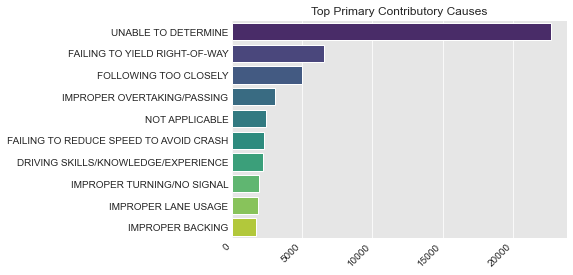

In [68]:
#Determining the top 
top_10_crash_causes = top_causes = crashes["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(10)

sns.barplot(x=top_causes.values, y=top_causes.index, palette="viridis")
plt.title("Top Primary Contributory Causes")
plt.xticks(rotation=45, ha="right")
plt.show()

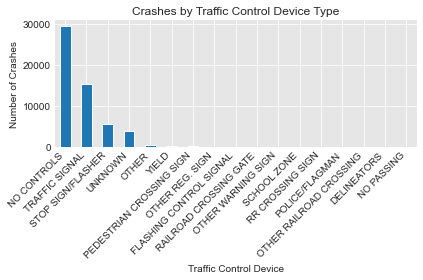

In [69]:
plt.figure()
crashes["TRAFFIC_CONTROL_DEVICE"].value_counts().plot(kind="bar")
plt.title("Crashes by Traffic Control Device Type")
plt.xlabel("Traffic Control Device")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


A high number of accidents occured in areas with no controls(road signs, speed limits, pedestrian crossing etc.)

In [70]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120061 entries, 0 to 120060
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PERSON_ID              120061 non-null  object 
 1   PERSON_TYPE            120061 non-null  object 
 2   CRASH_RECORD_ID        120061 non-null  object 
 3   VEHICLE_ID             116677 non-null  float64
 4   CRASH_DATE             120061 non-null  object 
 5   SEAT_NO                23368 non-null   float64
 6   CITY                   87732 non-null   object 
 7   STATE                  89192 non-null   object 
 8   ZIPCODE                83249 non-null   object 
 9   SEX                    117848 non-null  object 
 10  AGE                    86279 non-null   float64
 11  DRIVERS_LICENSE_STATE  71646 non-null   object 
 12  DRIVERS_LICENSE_CLASS  56520 non-null   object 
 13  SAFETY_EQUIPMENT       119761 non-null  object 
 14  AIRBAG_DEPLOYED        116809 non-nu

In [71]:
people.duplicated().sum()

0

In [72]:
people.isna().sum()

PERSON_ID                     0
PERSON_TYPE                   0
CRASH_RECORD_ID               0
VEHICLE_ID                 3384
CRASH_DATE                    0
SEAT_NO                   96693
CITY                      32329
STATE                     30869
ZIPCODE                   36812
SEX                        2213
AGE                       33782
DRIVERS_LICENSE_STATE     48415
DRIVERS_LICENSE_CLASS     63541
SAFETY_EQUIPMENT            300
AIRBAG_DEPLOYED            3252
EJECTION                   1738
INJURY_CLASSIFICATION        13
HOSPITAL                 105315
EMS_AGENCY               111164
EMS_RUN_NO               118551
DRIVER_ACTION             23580
DRIVER_VISION             23627
PHYSICAL_CONDITION        23513
PEDPEDAL_ACTION          116736
PEDPEDAL_VISIBILITY      116743
PEDPEDAL_LOCATION        116738
BAC_RESULT                23615
BAC_RESULT VALUE         119954
CELL_PHONE_USE           120059
dtype: int64

In [73]:
people["PHYSICAL_CONDITION"].value_counts()

NORMAL                          58425
UNKNOWN                         36085
EMOTIONAL                         604
IMPAIRED - ALCOHOL                382
REMOVED BY EMS                    342
OTHER                             253
FATIGUED/ASLEEP                   241
ILLNESS/FAINTED                    88
HAD BEEN DRINKING                  50
IMPAIRED - ALCOHOL AND DRUGS       38
IMPAIRED - DRUGS                   28
MEDICATED                          12
Name: PHYSICAL_CONDITION, dtype: int64

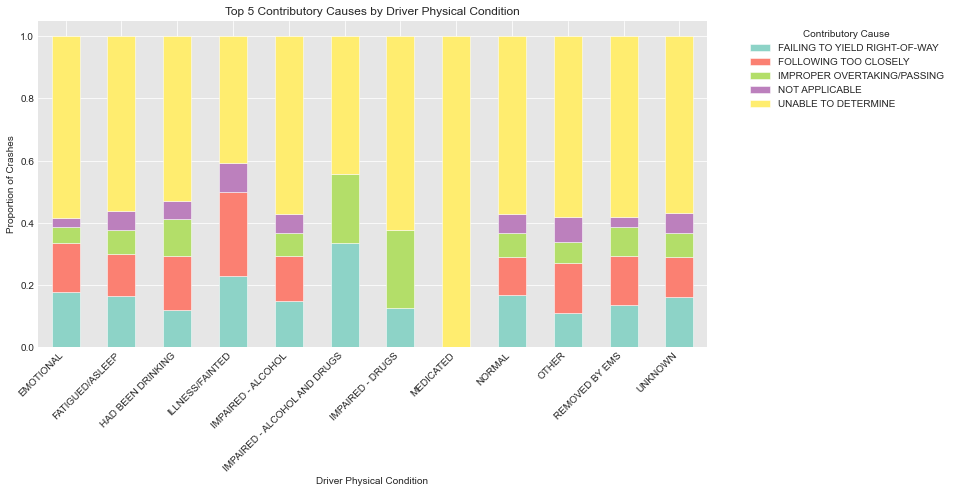

In [74]:
#Determining top causes for accidents by driver condition
top_causes = crashes["PRIM_CONTRIBUTORY_CAUSE"].value_counts().head(5).index

df_top = crashes[crashes["PRIM_CONTRIBUTORY_CAUSE"].isin(top_causes)]

ct_top = pd.crosstab(
    people["PHYSICAL_CONDITION"],
    df_top["PRIM_CONTRIBUTORY_CAUSE"],
    normalize="index"
)


plt.figure(figsize=(12, 6))
ct_top.plot(kind="bar", stacked=True, ax=plt.gca(), colormap='Set3', edgecolor='white', linewidth=0.5)
plt.title("Top 5 Contributory Causes by Driver Physical Condition")
plt.ylabel("Proportion of Crashes")
plt.xlabel("Driver Physical Condition")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Contributory Cause',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

In [75]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111727 entries, 0 to 111726
Data columns (total 71 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CRASH_UNIT_ID             111727 non-null  int64  
 1   CRASH_RECORD_ID           111727 non-null  object 
 2   CRASH_DATE                111727 non-null  object 
 3   UNIT_NO                   111727 non-null  int64  
 4   UNIT_TYPE                 111651 non-null  object 
 5   NUM_PASSENGERS            16020 non-null   float64
 6   VEHICLE_ID                108262 non-null  float64
 7   CMRC_VEH_I                2030 non-null    object 
 8   MAKE                      108262 non-null  object 
 9   MODEL                     108262 non-null  object 
 10  LIC_PLATE_STATE           98787 non-null   object 
 11  VEHICLE_YEAR              93284 non-null   float64
 12  VEHICLE_DEFECT            108262 non-null  object 
 13  VEHICLE_TYPE              108262 non-null  o

## Data Cleaning and Preprocessing

In [76]:
#Columns to be used in analysis
crashes_cols = crashes[["CRASH_RECORD_ID", "CRASH_DATE", "POSTED_SPEED_LIMIT", "TRAFFIC_CONTROL_DEVICE", "WEATHER_CONDITION", "LIGHTING_CONDITION", "ROAD_DEFECT", "PRIM_CONTRIBUTORY_CAUSE","ROADWAY_SURFACE_COND"]]
people_cols = people[["CRASH_RECORD_ID", "CRASH_DATE", "PHYSICAL_CONDITION", "DRIVER_ACTION"]]
vehicles_cols = vehicles[["CRASH_RECORD_ID", "CRASH_DATE", "VEHICLE_DEFECT"]]

## Feature Engineering

In [77]:
drivers = people[people["PERSON_TYPE"] == "DRIVER"].copy()

drivers["ALCOHOL_POSITIVE"] = drivers["BAC_RESULT VALUE"] > 0

drivers["FATIGUED"] = drivers["PHYSICAL_CONDITION"] == "FATIGUED/ASLEEP"
drivers["DRUG_IMPAIRED"] = drivers["PHYSICAL_CONDITION"] == "IMPAIRED - DRUGS"
drivers["ALCOHOL_IMPAIRED"] = drivers["PHYSICAL_CONDITION"] == "IMPAIRED - ALCOHOL"



In [78]:
drivers = people[people["PERSON_TYPE"] == "DRIVER"]

people_agg = drivers.groupby("CRASH_RECORD_ID").agg(
    avg_driver_age=("AGE", "mean"),
    any_alcohol=("BAC_RESULT VALUE", lambda x: (x > 0).any()),
    any_fatigued=("PHYSICAL_CONDITION", lambda x: (x == "FATIGUED/ASLEEP").any())
).reset_index()


In [79]:
vehicles_agg = vehicles.groupby("CRASH_RECORD_ID").agg(
    num_vehicles=("CRASH_UNIT_ID", "count"),
    any_speeding=("EXCEED_SPEED_LIMIT_I", lambda x: (x == "Y").any()),
    motorcycle_involved=("VEHICLE_TYPE", lambda x: (x == "MOTORCYCLE").any())
).reset_index()


In [80]:
vehicles["speeding"] = vehicles["EXCEED_SPEED_LIMIT_I"] == "Y"


In [81]:
crashes["traffic_control_present"] = np.where(
    crashes["TRAFFIC_CONTROL_DEVICE"] == "NO CONTROLS",
    0, 1
)


In [82]:
#Merging the datasets
df = (
    crashes_cols
    .merge(people_agg, on="CRASH_RECORD_ID", how="inner")
    .merge(vehicles_agg, on="CRASH_RECORD_ID", how="inner")
)



In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54719 entries, 0 to 54718
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_RECORD_ID          54719 non-null  object 
 1   CRASH_DATE               54719 non-null  object 
 2   POSTED_SPEED_LIMIT       54719 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   54719 non-null  object 
 4   WEATHER_CONDITION        54719 non-null  object 
 5   LIGHTING_CONDITION       54719 non-null  object 
 6   ROAD_DEFECT              54719 non-null  object 
 7   PRIM_CONTRIBUTORY_CAUSE  54719 non-null  object 
 8   ROADWAY_SURFACE_COND     54719 non-null  object 
 9   avg_driver_age           44142 non-null  float64
 10  any_alcohol              54719 non-null  bool   
 11  any_fatigued             54719 non-null  bool   
 12  num_vehicles             54719 non-null  int64  
 13  any_speeding             54719 non-null  bool   
 14  motorcycle_involved   

In [84]:
df.shape

(54719, 15)

In [85]:
#Cleaning the merged dataset
df.isna().sum()

CRASH_RECORD_ID                0
CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
ROAD_DEFECT                    0
PRIM_CONTRIBUTORY_CAUSE        0
ROADWAY_SURFACE_COND           0
avg_driver_age             10577
any_alcohol                    0
any_fatigued                   0
num_vehicles                   0
any_speeding                   0
motorcycle_involved            0
dtype: int64

In [86]:
df["avg_driver_age"] = df["avg_driver_age"].fillna(
    df["avg_driver_age"].median()
)


In [87]:
df.isna().sum()

CRASH_RECORD_ID            0
CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
ROADWAY_SURFACE_COND       0
avg_driver_age             0
any_alcohol                0
any_fatigued               0
num_vehicles               0
any_speeding               0
motorcycle_involved        0
dtype: int64

In [88]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
54714    False
54715    False
54716    False
54717    False
54718    False
Length: 54719, dtype: bool

In [92]:
df["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

UNABLE TO DETERMINE                                                                 22582
FAILING TO YIELD RIGHT-OF-WAY                                                        6507
FOLLOWING TOO CLOSELY                                                                4988
IMPROPER OVERTAKING/PASSING                                                          3032
NOT APPLICABLE                                                                       2418
FAILING TO REDUCE SPEED TO AVOID CRASH                                               2263
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  2176
IMPROPER TURNING/NO SIGNAL                                                           1898
IMPROPER LANE USAGE                                                                  1832
IMPROPER BACKING                                                                     1703
DISREGARDING TRAFFIC SIGNALS                                                         1039
WEATHER   

In [96]:
#Scaling the data
scaler = StandardScaler

df_scaled = scaler(df)

c:\Users\This pc\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass copy=                                         CRASH_RECORD_ID  \
0      d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...   
1      b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...   
2      bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...   
3      40064b1f9d498293c9392d4c89bb60128409738a3c44d1...   
4      efce3ab254c9daaacb6ce6a60e10e8cb8ca50ab3f7ea5b...   
...                                                  ...   
54714  bc8d75885e527a22b94bd0b0bb97d50249602c50b83a03...   
54715  b458eff531f6d9fc31692c952200156d32bb71a65c16eb...   
54716  cd66d308fdfb1f8569c9099b7c277350ea60c2282ebb33...   
54717  27cac294068eb0f9f1da60443c1a2b0f008e89586615bd...   
54718  cfbcfa69ab56f73ee82924ca064b912c04cf953c7ebd6b...   

                   CRASH_DATE  POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE  \
0      12/30/2025 11:50:00 PM                  35         TRAFFIC SIGNAL   
1      12/

In [ ]:
#Combining the primary causes into new categories
cause_map = {
    "FAILING TO YIELD RIGHT OF WAY": "DRIVER_ERROR/NEGLIGENCE",
    "FOLLOWING TOO CLOSELY": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER OVERTAKING/PASSING": "DRIVER_ERROR/NEGLIGENCE",
    "FAILING TO REDUCE SPEED TO AVOID CRASH": "SPEEDING",
    "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER TURNING/NO SIGNAL": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER LANE USAGE": "DRIVER_ERROR/NEGLIGENCE",
    "IMPROPER BACKING": "DRIVER_ERROR/NEGLIGENCE", 
    "DISREGARDING TRAFFIC SIGNALS": "DRIVER_ERROR/NEGLIGENCE",
    "WEATHER": "WEATHER",
    "OPERATING VEHICLE IN ERATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER": "DRIVER_ERROR/NEGLIGENCE",
    "DISREGARDING STOP SIGN": "DRIVER_ERROR/NEGLIGENCE",
    "DRIVING ON WRONG SIDE": "DRIVER_ERROR/NEGLIGENCE",
    "DISTRACTION - FROM INSIDE VEHICLE": "DISTRACTION",
    "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)":"OBSCURED VISION",
    "EQUIPMENT - VEHICLE CONDITION": "VEHICLE_CONDITION",
    "DISTRACTION - FROM OUTSIDE VEHICLE": "DISTRACTION", 
    "DISREGARDING OTHER TRAFFIC SIGNS": "DRIVER_ERROR/NEGLIGENCE",
    "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": "EVASIVE_ACTION",
    "DISREGARDING ROAD MARKINGS": "DRIVER_ERROR/NEGLIGENCE",
    "ROAD CONSTRUCTION/MAINTENANCE": "ROAD_WORK",
    "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": "POOR_ROAD_CONDITION",
    "CELLPHONE USE OTHER THAN TEXTING": "MOBILE_PHONE_USE",
    "ANIMAL": "EVASIVE_ACTION",
    "TURNING RIGHT ON RED": "DRIVER_ERROR/NEGLIGENCE", 
    "RELATED TO BUS STOP": "OTHER",
    "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": "DISTRACTION",
    "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": "ALCOHOL/DRUG_IMPAIRMENT",
    "TEXTING": "DISTRACTION",
    "OBSTRUCTED CROSSWALKS": "POOR_ROAD_CONDITION"
    "ALCOHOL/DRUG IMPAIRMENT": "IMPAIRED",
    "IMPAIRED - ALCOHOL": "IMPAIRED",
    "IMPAIRED - DRUGS": "IMPAIRED",
    "DISTRACTION": "DISTRACTION",
    "CELL PHONE": "DISTRACTION",
    "TEXTING": "DISTRACTION",
    "FATIGUED/ASLEEP": "FATIGUE",
    "FAILURE TO YIELD": "OTHER",
    "UNABLE TO DETERMINE": "OTHER"
    
}


In [104]:
df["CAUSE_GROUPED"] = df["PRIM_CONTRIBUTORY_CAUSE"].map(cause_map)


In [105]:

df["CAUSE_GROUPED"].value_counts()

OTHER                      22582
DRIVER_ERROR/NEGLIGENCE    17340
SPEEDING                    2263
wEATHER                      689
DISTRACTION                  505
OBSCURED VISION              305
VEHICLE_CONDITION            295
EVASIVE_ACTION               133
ROAD_WORK                     70
POOR_ROAD_CONDITION           59
Name: CAUSE_GROUPED, dtype: int64